# 1. 이해하기

## 1.1 Context

context란 **에이전트와 해당 도구가 특정 작업을 수행하는 동안 사용할 수 있는 핵심 정보의 묶음**을 의미합니다. 이는 현재 작업이나 대화 턴을 효과적으로 처리하는 데 필요한 배경 지식 및 자원입니다. 컨텍스트는 대화의 여러 단계에 걸쳐 세부 정보(**사용자 선호도, 이전 계산 결과, 쇼핑 카트 품목** 등)를 기억하는 **상태(State)**를 유지하고, LLM 호출이나 도구 실행과 같은 한 단계에서 발견되거나 생성된 정보를 다음 단계로 전달하는 데 필수적입니다.


## 1.2 Conversational Context

Agent가 의미있게 대화를 이어가려면 사람처럼 이미 언급된 내용을 기억해야 합니다. 그렇지 않으면 대화가 반복되거나 단절됩니다. Google의 ADK는 세 가지 핵심 계층을 통해 이러한 대화 맥락을 체계적으로 관리할 수 있는 방법을 제공합니다.

*   **Session**: 사용자-에이전트 간의 진행 중인 상호 작용을 나타내며, **대화 중 메시지 및 작업의 전체 타임라인을 추적**합니다.
*   **State**: **현재 대화 스레드에만 관련된 임시 데이터를 저장**합니다. 이는 하나의 호출(invocation) 내에서 데이터를 공유하고, 선호도를 기억하며, 대화 메모리를 관리하는 주요 방법입니다. `context.state`를 통해 상태에 접근하고 수정할 수 있습니다. 상태 관리 시 `app:`, `user:`, `temp:`와 같은 접두사를 사용하여 범위를 지정할 수 있습니다.
*   **Memory**: **여러 과거 세션 또는 외부 데이터 소스에서 가져온 정보를 검색**할 수 있는 지식 베이스입니다. 에이전트가 즉각적인 대화를 넘어 정보나 컨텍스트를 회상하기 위해 검색할 수 있는 저장소 역할을 합니다.

- **Artifacts** : 세션 또는 사용자와 연관된 이름이 지정되고 버전이 관리되는 바이너리 데이터를 나타내는 중요한 메커니즘입니다. 이는 에이전트와 도구가 **단순 텍스트 문자열** 이상의 데이터를 처리할 수 있도록 해주며, **파일, 이미지, 오디오 등 다양한 바이너리 형식**을 포함하는 더 풍부한 상호작용을 가능하게 합니다

## 1.3 Context 종류

### 1.3.1 InvocationContext

ADK에서 단일 사용자 요청을 처리하는 동안의 **모든 정보를 담는 최상위 컨테이너**이며, **Runner에 의해 생성**되어 관리되고, 에이전트의 핵심 로직에서 주로 사용되며, **Session, Services, Identifier 등 해당 호출에 필요한 모든 컨텍스트를 제공**합니다. 다른 컨텍스트 객체들은 InvocationContext가 제공하는 정보를 특정 작업(콜백, 도구 실행)에 맞게 접근하고 조작할 수 있도록 돕는 역할을 합니다.

### 1.3.2 ReadonlyContext

ReadonlyContext는 이름에서 알 수 있듯이, 에이전트 실행 주기 동안 특정 시점에서 **읽기 전용(Read-only)으로 기본적인 컨텍스트 정보에 접근할 수 있도록 제공**되는 객체입니다. 이 컨텍스트는 **정보를 조회**하는 것이 주 목적인 상황에서 사용되며, 상태(state)를 변경하거나 아티팩트/메모리 서비스와 상호작용하는 등의 쓰기 작업은 허용되지 않습니다.
InvocationContext, CallbackContext, ToolContext 등 **다른 컨텍스트 객체들의 기본 클래스(Base Class) 역할**을 합니다. 즉, 다른 컨텍스트 객체들은 ReadonlyContext가 제공하는 기본적인 읽기 기능을 상속받고, 각자의 목적에 맞는 추가적인 기능(상태 변경, 도구 실행, 아티팩트 관리, 인증 요청 등)을 덧붙인 형태입니다

### 1.3.3 CallbackContext

이름에서 알 수 있듯이, 에이전트 실행 주기 중 **특정 지점에서 코드를 삽입하여 에이전트의 동작을 관찰하거나 제어**할 수 있게 해주는 콜백 함수에 전달되는 컨텍스트 객체입니다. 개발자가 직접 CallbackContext 객체를 생성하는 경우는 드물며, ADK 프레임워크가 에이전트 라이프사이클의 특정 단계에서 해당 콜백 함수를 호출할 때 인자로 전달해 줍니다

**CallbackContext의 주요 사용 사례 (콜백 내에서):**
- **입력 검증 및 가드레일**: before_model_callback에서 사용자 입력(llm_request.contents)을 검사하여 부적절한 내용(PII, 욕설, 특정 키워드 등)이 포함된 경우 LLM 호출을 차단하고 미리 정의된 응답을 반환합니다.
- **동적 프롬프트 수정**: before_model_callback에서 세션 상태(callback_context.state)에 저장된 사용자 선호도나 기타 정보를 기반으로 LLM 요청(llm_request)의 시스템 지침(system_instruction)이나 기타 내용을 동적으로 수정합니다.
- **응답 후처리**: after_model_callback에서 LLM 응답(llm_response)을 검사하여 민감 정보를 검열하거나, 구조화된 데이터를 파싱하여 상태에 저장하거나, 응답 형식을 조정합니다.
- **상태 기반 동작 제어**: before_agent_callback에서 세션 상태의 특정 플래그를 확인하여 에이전트의 전체 실행을 건너뛰도록 하거나, after_agent_callback에서 상태에 따라 에이전트의 최종 응답을 수정하거나 교체합니다.
- **로깅 및 모니터링**: 콜백 함수 내에서 agent_name, invocation_id 등의 정보를 활용하여 특정 실행 단계의 로깅을 추가합니다.
- **아티팩트 저장/로딩**: 콜백 내에서 생성된 보고서 파일이나 기타 데이터를 save_artifact로 저장하거나, 이전에 저장된 설정 파일 등을 load_artifact로 불러와 에이전트 동작에 활용합니다

### 1.3.4 ToolContext

**에이전트가 tool을 실행할 때 tool 함수나 tool 실행 콜백에 전달되는 특별한 컨텍스트 객체**입니다. 이 객체는 tool이 작업을 수행하는 데 필요한 정보와 ADK 프레임워크와 상호작용할 수 있는 기능들을 제공합니다

#### 1.3.4.1 ToolContext의 주요 내용 및 역할

1. **자동 주입 (tool_context: ToolContext 파라미터):** FunctionTool로 래핑된 Python 함수의 시그니처에 **tool_context: ToolContext라는 이름의 파라미터를 포함**시키면, ADK 프레임워크가 해당 도구가 호출될 때 이 **객체를 자동으로 주입**해 줍니다. 이는 도구의 핵심 로직에 필요한 **정보와 기능을 제공하는 "다리(bridge)" 역할**을 합니다. LLM이 도구 호출을 결정할 때는 tool_context 파라미터에 대해 알 필요가 없으므로, 도구 함수의 **docstring에는 이 파라미터를 설명하지 않아야 합니다.**

2. **상태(State) 관리 (tool_context.state):** ToolContext의 가장 중요한 기능 중 하나는 **현재 세션 상태에 대한 읽기 및 쓰기 접근을 제공**한다는 것입니다. tool_context.state는 **딕셔너리처럼 작동**하며, 여기에서 상태를 읽거나(get 메서드 사용 권장), 값을 할당하여 상태를 변경할 수 있습니다. app:, user:, temp:와 같은 상태 스코프 접두사를 사용할 수 있습니다. ToolContext.state에 대한 변경은 현재 단계의 이벤트에 자동으로 기록되어(EventActions.state_delta) SessionService에 의해 영속화됩니다. 이는 **tool 실행 간에 데이터를 공유**하거나, **사용자 선호도를 업데이트**하거나, **임시 결과를 저장**하는 데 사용됩니다.

3. **아티팩트(Artifacts) 관리:** ToolContext를 통해 구성된 ArtifactService와 상호작용할 수 있습니다.
  - **save_artifact(filename, artifact)**: 파일을 저장하고 버전 번호를 할당합니다. 저장 작업은 이벤트에 기록됩니다.
  - **load_artifact(filename, version)**: 저장된 파일을 버전(기본값은 최신)을 지정하여 불러옵니다.
  - **list_artifacts()**: 현재 스코프(세션 또는 사용자)에서 접근 가능한 모든 아티팩트 파일 이름 목록을 반환합니다. 이 메서드는 ToolContext에만 있고 CallbackContext에는 없습니다. 이 기능들을 사용하려면 Runner에 ArtifactService 구현체가 설정되어 있어야 합니다.

4. **메모리 검색 (search_memory(query))**: 구성된 MemoryService를 쿼리하여 과거 상호작용이나 외부 지식 소스에서 관련 정보를 검색할 수 있습니다.

5. **인증(Authentication) 처리:** 인증이 필요한 도구를 개발할 때 ToolContext를 사용합니다.
  - **request_credential(auth_config):** 인증 흐름을 시작해야 함을 프레임워크에 알립니다.
  - **get_auth_response(auth_config):** 사용자/시스템에 의해 제공된 자격 증명(credentials)을 검색합니다.
  - **auth_response:** 프레임워크가 도구 호출 전에 인증을 미리 처리한 경우 자격 증명이 포함될 수 있습니다. 획득한 자격 증명은 tool_context.state에 저장하여 캐싱할 수 있습니다.

6. **에이전트 흐름 제어 (tool_context.actions):** actions 속성은 EventActions 객체를 가지고 있으며, 이를 수정하여 도구 실행 완료 후 에이전트의 다음 행동에 영향을 줄 수 있습니다.
  - **skip_summarization = True:** 도구 출력에 대한 LLM 요약 단계를 건너뛰도록 지시합니다.
  - **transfer_to_agent = "다른 에이전트 이름":** 현재 에이전트 실행을 중지하고 지정된 다른 에이전트로 대화 제어를 넘깁니다.

7. **식별자 및 추적:** ToolContext는 현재 호출 및 도구 실행에 대한 식별 정보를 제공합니다.
  - invocation_id: 전체 사용자 요청 처리 주기의 고유 ID.
  - agent_name: 현재 에이전트의 이름.
  - function_call_id: 이 도구 실행을 유발한 LLM의 특정 함수 호출에 대한 고유 ID. 인증 요청/응답을 연결하는 데 중요합니다.
  - function_call_event_id: 현재 도구 호출을 트리거한 이벤트의 고유 ID.

8. **도구 가드레일:** ToolContext를 통해 개발자가 미리 설정한 정보(예: 상태에 저장된 정책)에 접근하여 LLM이 생성한 도구 인자를 검증하거나 부적절한 도구 실행을 차단하는 가드레일을 구현할 수 있습니다. before_tool_callback에서 ToolContext를 받아 인자를 검사하고, 유효하지 않으면 딕셔너리를 반환하여 도구 실행을 막고 결과를 대체할 수 있습니다.

## 1.4 flow

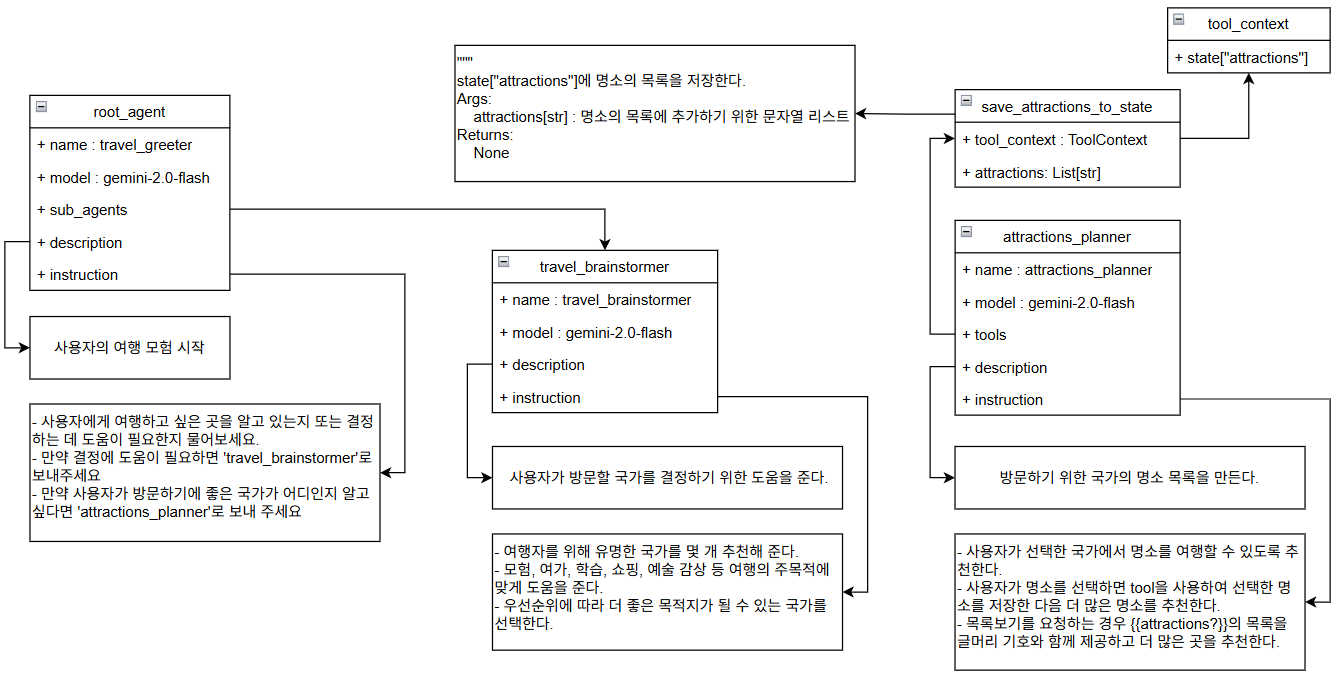

## 1.5 실행 결과

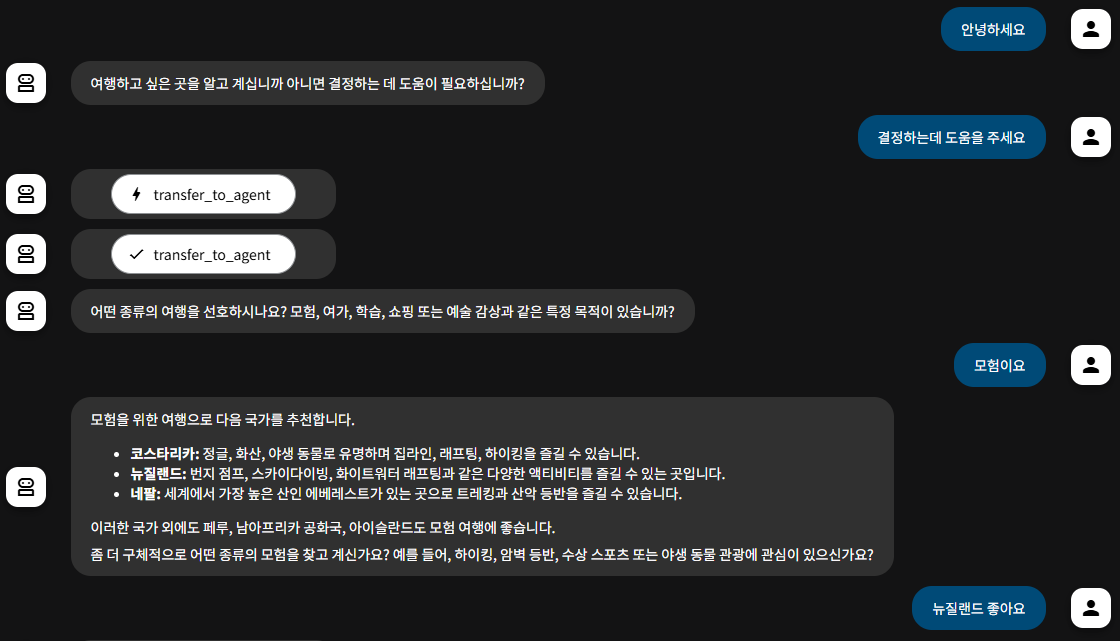

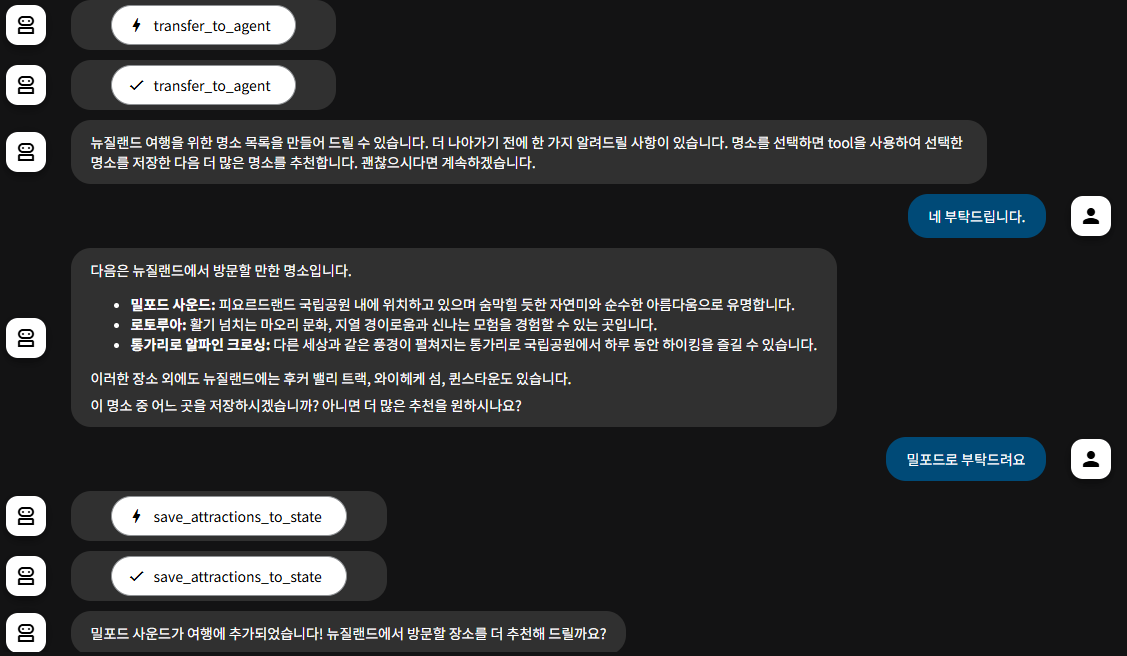

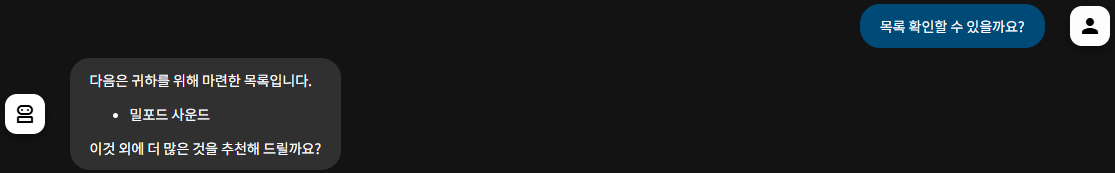

# 2. code



```
from google.adk import Agent
from google.adk.tools.tool_context import ToolContext
from typing import List

model_name="gemini-2.0-flash"

def save_attractions_to_state(
    tool_context: ToolContext,
    attractions: List[str]
)->dict[str,str]:
    """
    state["attractions"]에 명소의 목록을 저장한다.
    Args:
        attractions[str]: 명소의 목록에 추가히기 위한 문자열 리스트
    Returns:
        dict[str,str]: 성공메시지
    """
    existing_attractions = tool_context.state.get("attractions", [])

    tool_context.state["attractions"] = existing_attractions + attractions

    return {"status": "success"}

attractions_planner = Agent(
    name= "attractions_planner",
    model=model_name,
    description="방문하기 위한 국가의 명소 목록을 만든다.",
    instruction="""
        - 사용자가 선택한 국가에서 명소를 여행할 수 있도록 추천한다.
        - 사용자가 명소를 선택하면 tool을 사용하여 선택한 명소를 저장한 다음 더 많은 명소를 추천한다.
        - 목록보기를 요청하는 경우 {{attractions?}}의 목록을 글머리 기호와 함께 제공하고 더 많은 곳을 추천한다.
    """,
    tools=[save_attractions_to_state]
)

travel_brainstormer = Agent(
    name= "travel_brainstormer",
    model=model_name,
    description=" 사용자가 방문할 국가를 결정하기 위한 도움을 준다.",
    instruction="""
    - 여행자를 위해 유명한 국가를 몇 개 추천해 준다.
    - 모험, 여가, 학습, 쇼핑, 예술 감상 등 여행의 주목적에 맞게 도움을 준다.
    - 우선순위에 따라 더 좋은 목적지가 될 수 있는 국가를 선택한다.
    """
)
root_agent=Agent(
    name="travel_greeter",
    model=model_name,
    description="사용자의 여행 모험 시작",
    instruction="""
    - 사용자에게 여행하고 싶은 곳을 알고 있는지 또는 결정하는 데 도움이 필요한지 물어보세요.
    - 만약 결정에 도움이 필요하면 'travel_brainstormer'로 보내주세요
    - 만약 사용자가 방문하기에 좋은 국가가 어디인지 알고 싶다면 'attractions_planner'로 보내 주세요
    """,
    sub_agents=[travel_brainstormer,attractions_planner]
)
```

